In [179]:
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from scipy.optimize import minimize


class RBM:

    def __init__(self, particles, dimensions, hidden, interaction):
        self.NumberParticles = particles
        self.Dimension = dimensions
        self.NumberHidden = hidden

        self.interaction=interaction

        # guess for parameters
        self.a=np.random.normal(loc=0.0, scale=0.1, size=(particles,dimensions))
        self.b=np.random.normal(loc=0.0, scale=0.1, size=(hidden))
        self.w=np.random.normal(loc=0.0, scale=0.1, size=(particles,dimensions,hidden))

# Trial wave function for the 2-electron quantum dot in two dims
    def wf(self, r,a,b,w):
        sigma=1.0
        sig2 = sigma**2
        Psi1 = 0.0
        Psi2 = 1.0
        Q = self.Qfac(r,b,w)
        
        for iq in range(self.NumberParticles):
            for ix in range(self.Dimension):
                Psi1 += (r[iq,ix]-a[iq,ix])**2
                
        for ih in range(self.NumberHidden):
            Psi2 *= (1.0 + np.exp(Q[ih]))
            
        Psi1 = np.exp(-Psi1/(2*sig2))

        return Psi1*Psi2

    # Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
    def LocalEnergy(self, r,a,b,w):
        sigma=1.0
        sig2 = sigma**2
        locenergy = 0.0
        
        Q = self.Qfac(r,b,w)

        for iq in range(self.NumberParticles):
            for ix in range(self.Dimension):
                sum1 = 0.0
                sum2 = 0.0
                for ih in range(self.NumberHidden):
                    sum1 += w[iq,ix,ih]/(1+np.exp(-Q[ih]))
                    sum2 += w[iq,ix,ih]**2 * np.exp(Q[ih]) / (1.0 + np.exp(Q[ih]))**2
        
                dlnpsi1 = -(r[iq,ix] - a[iq,ix]) /sig2 + sum1/sig2
                dlnpsi2 = -1/sig2 + sum2/sig2**2
                locenergy += 0.5*(-dlnpsi1*dlnpsi1 - dlnpsi2 + r[iq,ix]**2)
                
        if(self.interaction==True):
            for iq1 in range(self.NumberParticles):
                for iq2 in range(iq1):
                    distance = 0.0
                    for ix in range(self.Dimension):
                        distance += (r[iq1,ix] - r[iq2,ix])**2
                        
                    locenergy += 1/sqrt(distance)
                    
        return locenergy

    # Derivate of wave function ansatz as function of variational parameters
    def DerivativeWFansatz(self, r,a,b,w):
        
        sigma=1.0
        sig2 = sigma**2
        
        Q = self.Qfac(r,b,w)
        
        WfDer = np.empty((3,),dtype=object)
        WfDer = [np.copy(a),np.copy(b),np.copy(w)]
        
        WfDer[0] = (r-a)/sig2
        WfDer[1] = 1 / (1 + np.exp(-Q))
        
        for ih in range(self.NumberHidden):
            WfDer[2][:,:,ih] = w[:,:,ih] / (sig2*(1+np.exp(-Q[ih])))
                
        return  WfDer

    # Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
    def QuantumForce(self, r,a,b,w):

        sigma=1.0
        sig2 = sigma**2
        
        qforce = np.zeros((self.NumberParticles,self.Dimension), np.double)
        sum1 = np.zeros((self.NumberParticles,self.Dimension), np.double)
        
        Q = self.Qfac(r,b,w)
        
        for ih in range(self.NumberHidden):
            sum1 += w[:,:,ih]/(1+np.exp(-Q[ih]))
        
        qforce = 2*(-(r-a)/sig2 + sum1/sig2)
        
        return qforce
    
    def Qfac(self, r,b,w):
        """
        This is the Q factor used in the RBM wavefunction
        It is used in the computation of the wavefunction and the quantum force
        """
        Q = np.zeros((self.NumberHidden), np.double)
        temp = np.zeros((self.NumberHidden), np.double)
        
        for ih in range(self.NumberHidden):
            temp[ih] = (r*w[:,:,ih]).sum()
            
        Q = b + temp
        
        return Q
    
# Computing the derivative of the energy and the energy 
    def EnergyMinimization(self, a,b,w):

        NumberMCcycles= 10000
        # Parameters in the Fokker-Planck simulation of the quantum force
        D = 0.5
        TimeStep = 0.05
        # positions
        PositionOld = np.zeros((self.NumberParticles,self.Dimension), np.double)
        PositionNew = np.zeros((self.NumberParticles,self.Dimension), np.double)
        # Quantum force
        QuantumForceOld = np.zeros((self.NumberParticles,self.Dimension), np.double)
        QuantumForceNew = np.zeros((self.NumberParticles,self.Dimension), np.double)

        # seed for rng generator 
        seed()
        energy = 0.0
        DeltaE = 0.0

        EnergyDer = np.empty((3,),dtype=object)
        DeltaPsi = np.empty((3,),dtype=object)
        DerivativePsiE = np.empty((3,),dtype=object)
        EnergyDer = [np.copy(a),np.copy(b),np.copy(w)]
        DeltaPsi = [np.copy(a),np.copy(b),np.copy(w)]
        DerivativePsiE = [np.copy(a),np.copy(b),np.copy(w)]
        for i in range(3): EnergyDer[i].fill(0.0)
        for i in range(3): DeltaPsi[i].fill(0.0)
        for i in range(3): DerivativePsiE[i].fill(0.0)

        
        #Initial position
        for i in range(self.NumberParticles):
            for j in range(self.Dimension):
                PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
        wfold = self.wf(PositionOld,a,b,w)
        QuantumForceOld = self.QuantumForce(PositionOld,a,b,w)

        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position moving one particle at the time
            for i in range(self.NumberParticles):
                for j in range(self.Dimension):
                    PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                        QuantumForceOld[i,j]*TimeStep*D
                wfnew = self.wf(PositionNew,a,b,w)
                QuantumForceNew = self.QuantumForce(PositionNew,a,b,w)
                
                GreensFunction = 0.0
                for j in range(self.Dimension):
                    GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
                                        (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                        PositionNew[i,j]+PositionOld[i,j])
        
                GreensFunction = exp(GreensFunction)
                ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
                #Metropolis-Hastings test to see whether we accept the move
                if random() <= ProbabilityRatio:
                    for j in range(self.Dimension):
                        PositionOld[i,j] = PositionNew[i,j]
                        QuantumForceOld[i,j] = QuantumForceNew[i,j]
                    wfold = wfnew
    
            DeltaE = self.LocalEnergy(PositionOld,a,b,w)
            DerPsi = self.DerivativeWFansatz(PositionOld,a,b,w)
            
            DeltaPsi[0] += DerPsi[0]
            DeltaPsi[1] += DerPsi[1]
            DeltaPsi[2] += DerPsi[2]
            
            energy += DeltaE

            DerivativePsiE[0] += DerPsi[0]*DeltaE
            DerivativePsiE[1] += DerPsi[1]*DeltaE
            DerivativePsiE[2] += DerPsi[2]*DeltaE
                
        # We calculate mean values
        energy /= NumberMCcycles
        DerivativePsiE[0] /= NumberMCcycles
        DerivativePsiE[1] /= NumberMCcycles
        DerivativePsiE[2] /= NumberMCcycles
        DeltaPsi[0] /= NumberMCcycles
        DeltaPsi[1] /= NumberMCcycles
        DeltaPsi[2] /= NumberMCcycles
        EnergyDer[0]  = 2*(DerivativePsiE[0]-DeltaPsi[0]*energy)
        EnergyDer[1]  = 2*(DerivativePsiE[1]-DeltaPsi[1]*energy)
        EnergyDer[2]  = 2*(DerivativePsiE[2]-DeltaPsi[2]*energy)
        return energy, EnergyDer


    def train_rbm(self, silent=False):
        # Set up iteration using stochastic gradient method
        Energy = 0
        EDerivative = np.empty((3,),dtype=object)
        EDerivative = [np.copy(self.a),np.copy(self.b),np.copy(self.w)]
        # Learning rate eta, max iterations, need to change to adaptive learning rate
        eta = 0.001
        MaxIterations = 50
        iter = 0
        np.seterr(invalid='raise')
        Energies = np.zeros(MaxIterations)
        EnergyDerivatives1 = np.zeros(MaxIterations)
        EnergyDerivatives2 = np.zeros(MaxIterations)

        while iter < MaxIterations:
            Energy, EDerivative = self.EnergyMinimization(self.a,self.b,self.w)
            agradient = EDerivative[0]
            bgradient = EDerivative[1]
            wgradient = EDerivative[2]
            self.a -= eta*agradient
            self.b -= eta*bgradient 
            self.w -= eta*wgradient 
            Energies[iter] = Energy
            if not silent:
                print("Energy:",Energy)


            iter += 1
        return Energies


    def train_rbm_mead(self, silent=False):
        # Set up the optimization problem, including bounds if necessary.
        initial_guess = np.concatenate((self.a.flatten(), self.b.flatten(), self.w.flatten()))  # Concatenate all your parameters into a single 1D array
        bounds = None  # if necessary, define bounds for each parameter

        num_a_params = self.a.size  # or directly use the number if known
        num_b_params = self.b.size  # or directly use the number if known
        Energies = []
        def objective_function(params):
            # This function should separate out the parameters and evaluate the energy.
            
            a_params = params[:num_a_params].reshape(self.a.shape)
            b_params = params[num_a_params:num_a_params+num_b_params]
            w_params = params[num_a_params+num_b_params:].reshape(self.w.shape)
            
            energy, _ = self.EnergyMinimization(a_params, b_params, w_params)
            Energies.append(energy)
            return energy

        # Call the minimization routine.
        result = minimize(objective_function, initial_guess, method='nelder-mead', options={'disp': not silent, 'maxiter': 50, 'xatol': 1e-8, 'adaptive': True})

        # Extract the optimized parameters from the result
        optimized_params = result.x
        self.a = optimized_params[:num_a_params].reshape(self.a.shape)
        self.b = optimized_params[num_a_params:num_a_params+num_b_params]
        self.w = optimized_params[num_a_params+num_b_params:].reshape(self.w.shape)

        # If needed, you can return or print the final energy, or do something with the result object
        if not silent:
            print("Final Energy:", result.fun)

        # Return the result (optional)
        return Energies


/var/folders/gg/pt9rjjws0_b60pgd3qk984140000gn/T/ipykernel_50086/1280109863.py:268: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(objective_function, initial_guess, method='nelder-mead', options={'disp': not silent, 'maxiter': 50, 'xatol': 1e-8, 'adaptive': True})


Final Energy: 2.0089848419894625
Energy: 2.006182641474486
Energy: 2.0042082422110945
Energy: 2.002099823386709
Energy: 2.00727854297925
Energy: 2.0024616586246746
Energy: 2.0053827171744936
Energy: 2.008156346485268
Energy: 1.9999913202859911
Energy: 2.0018641116610536
Energy: 2.000979046214429
Energy: 1.9989964159546239
Energy: 2.010667516201707
Energy: 2.0078291535199293
Energy: 2.0077600476885187
Energy: 2.010247104275523
Energy: 2.008051010793185
Energy: 2.004981123693601
Energy: 2.0088198653322857
Energy: 2.0093997116103206
Energy: 2.00593357576078
Energy: 2.0082578758642993
Energy: 2.007960582608918
Energy: 2.0039139070193315
Energy: 2.0014204864155496
Energy: 2.0054311876803683
Energy: 2.0026089074210924
Energy: 2.0026094810991952
Energy: 2.011821223785612
Energy: 2.008427646909158
Energy: 2.000041549284625
Energy: 2.006705599263238
Energy: 2.001156787874263
Energy: 2.0038814039323616
Energy: 2.002733020696227
Energy: 2.0057206898638955
Energy: 2.0069706938113896
Energy: 2.0065

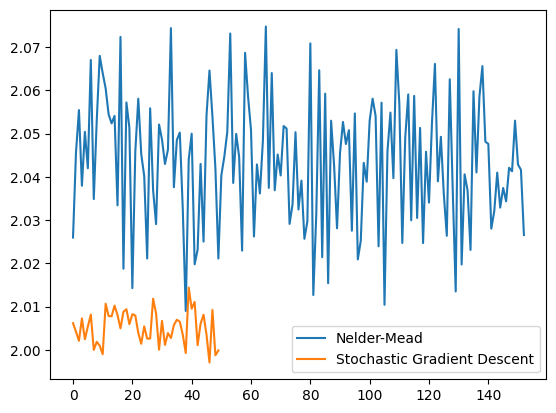

In [180]:
rbm = RBM(2,2,2,0)
energies1 = rbm.train_rbm_mead(silent=False)
rbm = RBM(2,2,2,0)
energies2 = rbm.train_rbm(silent=False)

plt.plot(energies1, label="Nelder-Mead")
plt.plot(energies2, label="Stochastic Gradient Descent")
plt.legend()


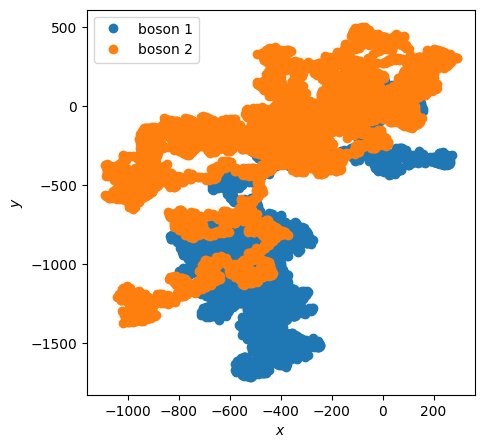

In [51]:
samples = rbm.generate_samples(n_samples=10000, gibbs_steps=100)

# Plot the samples
plt.figure(figsize=(5, 5))
plt.plot(samples[:, 0, 0], samples[:, 0, 1], 'o', label='boson 1')
plt.plot(samples[:, 1, 0], samples[:, 1, 1], 'o', label='boson 2')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()

In [52]:
# Define the discriminator model: this can be a simple feed-forward neural network
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid() # Sigmoid since we're doing binary classification
        )
    
    def forward(self, x):
        output = self.model(x)
        return output

def build_discriminator():
    # model will be a simple FFNN
    model = Discriminator(input_dim=2)
    criterion = nn.BCELoss() # Binary cross entropy loss since we're doing binary classification
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) # Using Adam optimizer as mentioned in the paper


    return model

# Use the existing RBM as the generator
def build_generator():
    rbm_true = init_rbm(2,2,2,0)
    rbm_fake = init_rbm(2,2,2,1)

    
    model = ... # This would be your RBM model
    return model

# Combined network
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = ... # Combined model where the generator produces a state and the discriminator evaluates it
    model.compile(loss='binary_crossentropy', optimizer=...)
    return model

# Instantiate the models
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


NameError: name 'init_rbm' is not defined

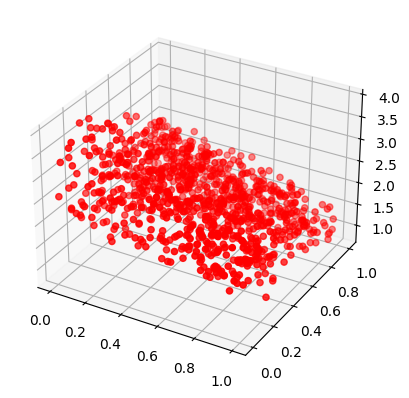

In [15]:
NumberParticles = 2
Dimension = 2
coordinates = []
rbm_generations = []
for i in range(1000):
    coordinates.append(np.random.uniform(-30,30,(NumberParticles,Dimension)))
    rbm_generations.append(rbm(coordinates[i],a,b,w))

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = [coordinates[i][0,0] for i in range(len(coordinates))]
y = [coordinates[i][0,1] for i in range(len(coordinates))]
z = [rbm_generations[i] for i in range(len(coordinates))]
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

In [56]:
class FeedforwardNeuralNetwork:
    def __init__(self, layer_sizes, activation_functions):
        self.layer_sizes = layer_sizes
        self.activation_functions = activation_functions  # assuming this is a list of functions, one for each layer
        self.parameters = {}
        #self._initialize_parameters()

    #def _initialize_parameters(self):
        # (Your logic for initializing the network parameters)

    def __str__(self):
        """
        Construct a string representation of the neural network architecture.
        """
        # Start the network representation with the 'input layer'
        network_representation = "Input Layer: {} neurons\n".format(self.layer_sizes[0])

        # Add hidden layers' details
        for i in range(1, len(self.layer_sizes) - 1):
            layer_info = "Hidden Layer {}: {} neurons, Activation Function: {}\n".format(
                i, 
                self.layer_sizes[i], 
                self.activation_functions[i]  # assuming the activation function is a callable with a name
            )
            network_representation += layer_info

        # Add the output layer details
        network_representation += "Output Layer: {} neurons".format(self.layer_sizes[-1])

        return network_representation

    # (Other methods like forward pass, backpropagation, etc.)

# Usage
layer_sizes = [784, 128, 64, 10]  # Example: for a network handling MNIST data
activation_functions = [None, 'relu', 'relu', 'softmax']  # Example: names of the activation functions
activations + activations[::-1]
network = FeedforwardNeuralNetwork(layer_sizes, activation_functions)
print(network)


Input Layer: 784 neurons
Hidden Layer 1: 128 neurons, Activation Function: relu
Hidden Layer 2: 64 neurons, Activation Function: relu
Output Layer: 10 neurons


In [59]:
layer_sizes = [784, 128, 64, 10]
activations = ['relu', 'relu', 'softmax']  # Example: names of the activation functions
activations + [activations[-1]] * (len(layer_sizes) - len(activations))

['relu', 'relu', 'softmax', 'softmax']

In [61]:
def teste(var1, **kwargs):
    print(kwargs["a"])

teste(1, a=2, b=3)

2


In [100]:
teste = np.array([7,8,9])
keys = ["a", "b"]

dict1 = {key: np.empty(teste.shape) for key in keys}

dict2 = {"a":np.array([7,8,9]), "b":np.array([10,11,12])}

dict3 = {"a":np.array([7,8,9]), "b":np.array([10,11,12])}

for key in keys:
    dict1[key] = np.vstack((dict1[key], dict2[key], dict3[key]))






dict1

{'a': array([[3.5e-323, 4.0e-323, 4.4e-323],
        [7.0e+000, 8.0e+000, 9.0e+000],
        [7.0e+000, 8.0e+000, 9.0e+000]]),
 'b': array([[3.5e-323, 4.0e-323, 4.4e-323],
        [1.0e+001, 1.1e+001, 1.2e+001],
        [1.0e+001, 1.1e+001, 1.2e+001]])}

In [91]:
dict1 = {"a":np.empty((0,3)), "b":np.empty((0,3))}
print(dict1)

{'a': array([], shape=(0, 3), dtype=float64), 'b': array([], shape=(0, 3), dtype=float64)}


In [84]:
import numpy as np
import time

# Creating sample data
data1 = np.random.rand(100, 100)  # adjust size for your use case
data2 = np.random.rand(100, 100)

# Measuring time for np.append
start_time = time.time()

for _ in range(1000):  # adjust iterations for your use case
    data1 = np.append(data1, data2, axis=0)
append_time = time.time() - start_time
data1 = np.random.rand(10, 10)  # adjust size for your use case
data2 = np.random.rand(10, 10)
# Measuring time for np.vstack
start_time = time.time()
for _ in range(1000):  # adjust iterations for your use case
    data1 = np.vstack((data1, data2))
vstack_time = time.time() - start_time

print(f"Time taken by np.append: {append_time:.6f} seconds")
print(f"Time taken by np.vstack: {vstack_time:.6f} seconds")


Time taken by np.append: 6.578734 seconds
Time taken by np.vstack: 0.013304 seconds


In [163]:
a = np.random.randn(4, 4)
b = np.random.randn(4, 4)
c = np.random.randn(4, 4)

ab = np.vstack((a.reshape(-1, 1), np.expand_dims(b, axis=0)))

abc = np.vstack((ab, np.expand_dims(c, axis=0)))




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [165]:
dict_ = {"a":np.array([1,2,3]), "b":np.array([4,5,6])}

# unpack the dictionary


SyntaxError: invalid syntax (2555852530.py, line 3)

In [161]:

abc.shape

(3, 4, 4)

In [153]:
abc.shape

(12, 4)

In [150]:
ab.shape

(8, 4)

In [142]:
ab.shape

(2, 4, 4)

In [144]:
# create individual arrays
a = np.random.randn(4, 4)
b = np.random.randn(4, 4)
c = np.random.randn(4, 4)

# stacking a and b along a new axis (axis=0 by default)
ab = np.stack((a, b))

# Now you have 'ab' which is an array of shape (2, 4, 4) because you've added a new dimension.
# Next, you want to stack 'ab' with 'c'. But 'c' is of shape (4, 4), and you can't directly stack
# it with 'ab' without matching their dimensions.

# You need to expand 'c' to have the same number of dimensions as 'ab'.
# One of the ways to do it is to use np.expand_dims or np.newaxis to add an extra dimension:

c_expanded = np.expand_dims(c, axis=0)  # or you could use c[np.newaxis, :]
# c_expanded is now of shape (1, 4, 4)

# Now you can concatenate or stack 'ab' and 'c_expanded' along the first axis
abc = np.concatenate((ab, c_expanded), axis=0)

In [120]:
a*b

array([[[-4.95170378e-01,  5.85152993e-02,  1.83441386e-01,
          8.64680348e-01],
        [ 1.07360646e-01, -3.67958541e-01,  3.47783079e-01,
          4.07458888e-01],
        [ 7.30966609e-01,  7.35609041e-02, -4.97392924e-01,
          4.82642769e-01],
        ...,
        [-9.33897270e-02, -2.33959325e-01, -7.80410100e-01,
         -1.40531026e-01],
        [ 9.24650827e-03, -7.56740511e-01, -1.90644608e-01,
         -3.98802531e-02],
        [ 5.63004462e-02,  1.69859674e-02,  2.15593658e-01,
          7.02494828e-01]],

       [[-1.91826788e+00,  2.26685651e-01,  7.10643719e-01,
          3.34973297e+00],
        [ 4.15910339e-01, -1.42545492e+00,  1.34729608e+00,
          1.57847750e+00],
        [ 2.83173193e+00,  2.84971650e-01, -1.92687793e+00,
          1.86973648e+00],
        ...,
        [-3.61787623e-01, -9.06347953e-01, -3.02327380e+00,
         -5.44410905e-01],
        [ 3.58205592e-02, -2.93157887e+00, -7.38548679e-01,
         -1.54494316e-01],
        [ 2.181

In [181]:
import tensorflow as tf

# Define the generator network
class QuantumGenerator(tf.keras.Model):
    def __init__(self, num_particles):
        super(QuantumGenerator, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=128, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=num_particles * 3)  # assuming 3D positions for particles

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        positions = self.dense3(x)
        return positions

# Define the energy (discriminator) network
class EnergyDiscriminator(tf.keras.Model):
    def __init__(self):
        super(EnergyDiscriminator, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=128, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=1)  # outputting a scalar energy

    def call(self, positions):
        x = self.dense1(positions)
        x = self.dense2(x)
        energy = self.dense3(x)
        return energy

# Instantiate the networks
generator = QuantumGenerator(num_particles=5)  # example for 5 particles
discriminator = EnergyDiscriminator()

# Define the loss functions
def generator_loss(fake_energy):
    # The generator wants to minimize the estimated energy of the generated positions
    return tf.reduce_mean(fake_energy)

def discriminator_loss(real_energy, fake_energy):
    # The discriminator wants to correctly classify real and fake energies
    # This might need to be modified to correctly handle quantum energies
    return tf.reduce_mean(fake_energy) - tf.reduce_mean(real_energy)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(z):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate positions from random noise
        generated_positions = generator(z, training=True)

        # Calculate the energy of the generated positions
        fake_energy = discriminator(generated_positions, training=True)
        # Placeholder for real energy calculation based on physics
        real_energy = calculate_real_energy(generated_positions)  

        # Calculate losses
        gen_loss = generator_loss(fake_energy)
        disc_loss = discriminator_loss(real_energy, fake_energy)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to optimizers
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            z = tf.random.normal([10, 10])  # latent_dim is the dimension of the random noise vector
            train_step(z)


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [1]:
# DISCLAIMER: Idea and code structure from blackjax
from typing import Any
from typing import Iterable
from typing import Mapping
from typing import Union

import jax.numpy as jnp
import numpy as np

# from typing import Callable

Array = Union[np.ndarray, jnp.ndarray]  # either numpy or jax numpy array
PyTree = Union[
    Array, Iterable[Array], Mapping[Any, Array]
]  # either array, iterable of arrays or mapping of arrays

from dataclasses import dataclass


@dataclass(frozen=False)
class State:
    positions: PyTree
    logp: Union[float, PyTree]
    n_accepted: int
    delta: int




In [6]:
State(positions=np.array([[1,2,3], [1,2,3]]), logp=np.array([1,2]), n_accepted=0, delta=0)

State(positions=array([[1, 2, 3],
       [1, 2, 3]]), logp=array([1, 2]), n_accepted=0, delta=0)

In [5]:
np.array([1,2,3], [1,2,3])

TypeError: Field elements must be 2- or 3-tuples, got '1'

In [18]:
if 5:
    
    print("hello")

hello


In [14]:
# Importing various packages
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

#Trial wave function for quantum dots in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

#Local energy  for quantum dots in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# The Monte Carlo sampling with the Metropolis algo
def MonteCarloSampling():

    NumberMCcycles= 100000
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = StepSize * (random() - .5)
            wfold = WaveFunction(PositionOld,alpha,beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j] + StepSize * (random() - .5)
                wfnew = WaveFunction(PositionNew,alpha,beta)

                #Metropolis test to see whether we accept the move
                if random() < wfnew**2 / wfold**2:
                   PositionOld = PositionNew.copy()
                   wfold = wfnew
                   DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2

            #We calculate mean, variance and error ...
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
    return Energies, AlphaValues, BetaValues


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, BetaValues) = MonteCarloSampling()

print(Energies)


[[3.06062216 3.05047415 3.03742983 3.04196614 3.03300221 3.03100683
  3.03023299 3.02609793 3.02223028 3.01902929]
 [3.04190656 3.03684337 3.03942397 3.03263044 3.02356256 3.02495115
  3.01765071 3.01869937 3.0108163  3.01221875]
 [3.03953106 3.03105361 3.02651466 3.02066437 3.01799859 3.01513565
  3.01010719 3.01183969 3.00765146 3.0115982 ]
 [3.02346329 3.02364836 3.01869182 3.01699267 3.00986775 3.01323492
  3.00932719 3.00824621 3.0027595  3.00366266]
 [3.02582007 3.01437986 3.01370782 3.01343462 3.01096569 3.00595131
  3.00740232 3.00341231 3.00493008 3.00409712]
 [3.01742489 3.01349222 3.01163819 3.01076686 3.00930653 3.00563206
  3.00454803 3.00459743 3.00257607 3.00223845]
 [3.01576949 3.01429792 3.01161803 3.00861802 3.00704559 3.00682485
  3.00633921 3.00548116 3.00584544 3.00357422]
 [3.0112977  3.01118806 3.00970708 3.0090658  3.00749316 3.00764519
  3.00899261 3.00567971 3.00523883 3.00757222]
 [3.01171187 3.01088979 3.0120619  3.00913651 3.0096002  3.00548673
  3.01076419

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss, seed


class Walker:
    def __init__(self, position):
        self.position = np.array(position)
        self.weight = 1
def initialize_walkers(num_walkers, dimension):
    walkers = []
    for _ in range(num_walkers):
        position = np.random.rand(dimension)  # Initialize positions randomly
        walkers.append(Walker(position))
    return walkers

def diffuse_and_branch(walkers, timestep):
    new_walkers = []
    for walker in walkers:
        # Diffusion step
        walker.position += gauss(0, np.sqrt(timestep))

        # Local energy evaluation (placeholder, implement actual calculation)
        local_energy = local_energy_calculator(walker.position)

        # Branching step based on local energy
        num_offspring = int(np.exp(-timestep * (local_energy - reference_energy)) + np.random.rand())
        for _ in range(num_offspring):
            new_walkers.append(Walker(walker.position))

    return new_walkers


def local_energy_calculator(position):
    # Implement the local energy calculation for your system
    # This is a placeholder function
    return np.sum(position**2)


def dmc_step(walkers, timestep):
    walkers = diffuse_and_branch(walkers, timestep)
    return walkers


def dmc_simulation(initial_walkers, timestep, total_steps, reference_energy):
    walkers = initial_walkers
    energies = []
    for step in range(total_steps):
        walkers = dmc_step(walkers, timestep)
        total_energy = sum([local_energy_calculator(w.position) for w in walkers])
        energies.append(total_energy / len(walkers))
    return energies


In [ ]:
num_walkers = 1000
dimension = 2
timestep = 0.01
total_steps = 1000
reference_energy = 1.0  # Adjust based on expected energy scale

initial_walkers = initialize_walkers(num_walkers, dimension)
energies = dmc_simulation(initial_walkers, timestep, total_steps, reference_energy)

plt.plot(energies)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.show()


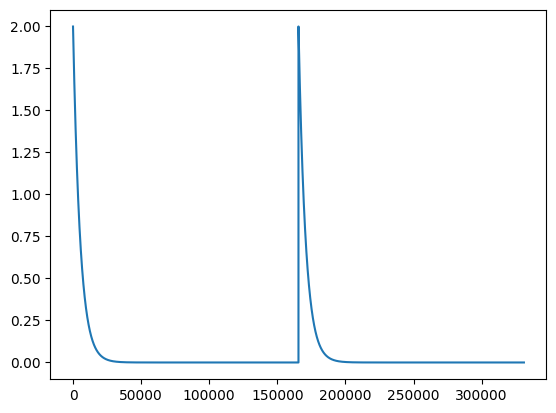

In [36]:
import pandas as pd

# read csv at /Users/haas/Documents/Masters/GANQS/src/simulation_scripts/decay.csv

df = pd.read_csv('/Users/haas/Documents/Masters/GANQS/src/decay.csv')

import matplotlib.pyplot as plt

plt.plot(df)


[0.         0.77966987 0.77966987 ... 1.         1.         1.        ]


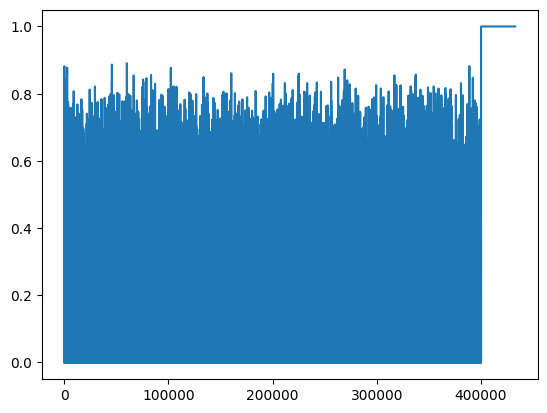

In [28]:
# open an npy file
import numpy as np

data = np.load('/Users/haas/Documents/Masters/GANQS/src/interac.npy')
print(data)

import matplotlib.pyplot as plt

plt.plot(data)

In [22]:
data[10]

0.27259863032341425

In [23]:
data[100]

0.2873273430183637

In [4]:
class test:
    def __init__(self):
        pass 

    def wf(self, r, alpha):
        print("alpha", alpha)

    def laplacian_closure_jax(self, r, alpha):
        """
        Return a function that computes the laplacian of the wavefunction
        """

        def wrapped_wf(r_):
            return self.wf(r_, alpha)
        
        wrapped_wf(r)
    


In [5]:
test1 = test()

test1.wf(1,2)



alpha 2


In [6]:
test1.laplacian_closure_jax(1,2)

alpha 2


In [32]:
import numpy as np

# random array of size 100, 4
exp_prod = np.random.rand(4,)
kernel2 = np.random.rand(4,4)

kernel2 @ exp_prod == np.einsum('ij,j->i', kernel2, exp_prod)

array([ True,  True,  True,  True])

In [10]:
r = np.random.rand(100, 4)

In [10]:
import numpy as np
def normalize_batch(batch_positions):
    """
    Normalize a batch of symmetrized position vectors.
    
    Parameters:
    - batch_positions: np.ndarray, a batch of symmetrized position vectors

    Returns:
    - normalized_batch_output: np.ndarray, normalized batch of vectors
    """
    # Compute normalization factor for the whole batch
    sym_f_of_r = np.mean(batch_positions, axis=-1) # example

    norm_factor = np.sqrt(np.sum(sym_f_of_r**2))
    normalized_batch_output = sym_f_of_r / norm_factor
    return normalized_batch_output

# Generate a batch of positions
n_particles, dims = 3, 2
batch_size = 5
batch_positions = np.random.rand(batch_size, n_particles*dims)

symmetrized_batch_output = normalize_batch(batch_positions)

print("Normalized and Symmetrized Batch output:\n", symmetrized_batch_output)


Normalized and Symmetrized Batch:
 [0.31744065 0.4839031  0.53789585 0.35917533 0.49671959]
1.0


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

def normalize_batch(batch_positions):
    sym_f_of_r = np.mean(batch_positions, axis=-1)  # Example symmetrization
    norm_factor = np.sqrt(np.sum(sym_f_of_r**2))
    normalized_batch_output = sym_f_of_r / norm_factor
    return normalized_batch_output

# Assuming the generator and discriminator are built using TensorFlow/Keras
def build_generator(input_dim): # this will actually be my VMC
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(input_dim))  # Output layer matches input dimensions
    return model

def build_discriminator(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=input_dim))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification (has symmetry or not?)
    return model

def compile_gan(generator, discriminator):
    # Compile the discriminator
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Make the discriminator not trainable when we are training the generator
    discriminator.trainable = False
    
    # Compile the combined model
    gan_input = layers.Input(shape=(generator.input_shape[1],))
    gan_output = discriminator(generator(gan_input))
    gan = models.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    
    return gan

# Placeholder for generator's forward function
def generator_forward(generator, batch_positions):
    # This function would actually use the generator (VMC) to generate its output
    # For illustration, it just returns a transformed version of the batch_positions
    return generator.predict(batch_positions)

# Error Calculation and Training Loop Skeleton
def train_gan(generator, discriminator, gan, batch_positions, epochs=1000, batch_size=128):
    for epoch in range(epochs):
        # Generate symmetrized positions (true states)
        true_states = normalize_batch(batch_positions)
        
        # Generate fake states using the generator
        fake_states = generator_forward(generator, batch_positions)
        
        # Labels for real and fake data
        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))
        
        # Train discriminator
        d_loss_real = discriminator.train_on_batch(true_states, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_states, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, generator.input_shape[1])) 
        g_loss = gan.train_on_batch(noise, real_y)
        
        # Log or print losses
        print(f"Epoch: {epoch} Discriminator Loss: {d_loss} Generator Loss: {g_loss}") # 

# Assuming dimensions for generator and discriminator inputs
input_dim = n_particles * dims  # Based on your setup

# Build and compile the models
generator = build_generator(input_dim)
discriminator = build_discriminator(input_dim)
gan = compile_gan(generator, discriminator)

# Example positions to start with (reshape to fit your true input requirements)
batch_positions = np.random.rand(batch_size, input_dim)

# Placeholder call to train the GAN (adjust with actual data and parameters)
# train_gan(generator, discriminator, gan, batch_positions)


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


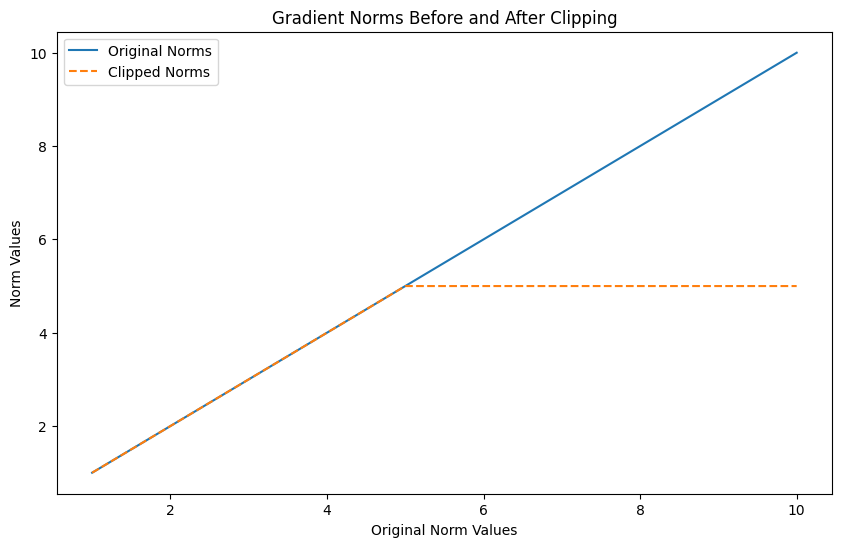

In [17]:
## gradient clip simultion 
import numpy as np
import matplotlib.pyplot as plt
# fake gradient values 

g_norms = np.random.rand(10) * 10

# construct random vectors with those norms
np.random.seed(0)  # For reproducibility
g = np.random.randn(10, 3)  # Assume gradient vectors in 3D space
g = g / np.linalg.norm(g, axis=1)[:, np.newaxis] * g_norms[:, np.newaxis]  # Normalize and scale


def grad_clip(g, lim):
    for i, g_i in enumerate(g):
        g_norm = np.linalg.norm(g_i)
        if g_norm > lim:
            g[i] = g_i * lim/g_norm



lim = 5  # Example limit for gradient clipping
grad_clip(g, lim)

#plot the norms versus the clipped norms
original_norms = g_norms
clipped_norms = np.linalg.norm(g, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(g_norms, original_norms, label='Original Norms')
plt.plot(g_norms, clipped_norms, label='Clipped Norms', linestyle='--')
plt.xlabel('Original Norm Values')
plt.ylabel('Norm Values')
plt.title('Gradient Norms Before and After Clipping')
plt.legend()
plt.show()


In [21]:
np.random.rand(10) * 10

array([8.37944907, 0.96098408, 9.76459465, 4.68651202, 9.76761088,
       6.0484552 , 7.39263579, 0.39187792, 2.82806963, 1.20196561])

In [27]:
from itertools import permutations
import math
import numpy as np


In [45]:
for sigma in permutations(range(3)):
    print(sigma)






(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)


In [33]:
def symmetrize(func):
    def h(*args):
        n = len(args)
        total = 0
        for sigma in permutations(range(n)):
            permuted_args = [args[i] for i in sigma]
            total += func(*permuted_args)
        return total / math.factorial(n)
    return h

# Example usage
def example_f(x, y, z):
    return 3*x*y**2 + 4*y**3 + 5*z*x

# Symmetrize the example function   
g = symmetrize(example_f)

# Test the symmetrized function
print(g(10, 20, 3))

[ 7 10]


TypeError: Test.function_sym() takes 2 positional arguments but 3 were given

In [37]:
np.zeros(2)


array([0., 0.])

In [35]:
r[0] + 2*r[1]

array([ 7, 10])

In [39]:
for i in permutations(range(3)):
    print(i)

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)


x.shape (10000, 2)


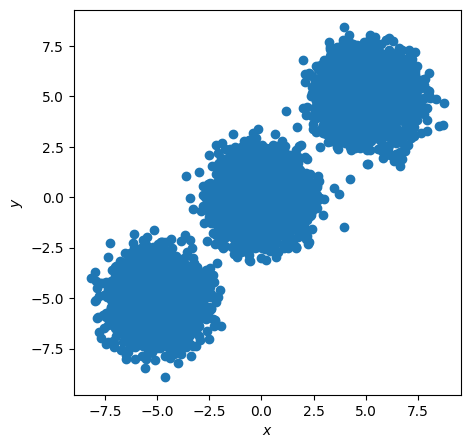

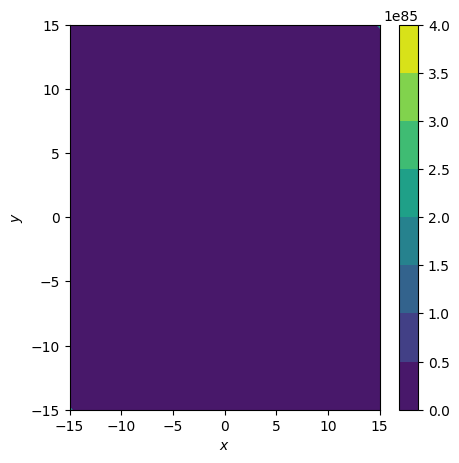

In [101]:
import numpy as np
import scipy.linalg as la

class MaximallySeparatedGaussianMixture:
    def __init__(self, particles, dim):
        self.particles = particles
        self.dim = dim
        self.range = 10
        separation = self.range / (particles)
        self.means = self.initialize_means()
        self.covariances = np.array([np.eye(dim) for _ in range(particles)])
        self.weights = np.ones(particles) / particles  # Equal weights for simplicity

    def initialize_means(self):
        """
        Initializes means to be maximally separated within each given dimension.
        
        """
        grid_points_per_dimension = self.particles
        
        grid = np.zeros((self.particles, self.dim))
        
        for i in range(self.dim):
            grid[:, i] = np.linspace(-self.range/2, self.range/2, grid_points_per_dimension)

        return grid
        


    def pdf(self, x):
        """
        Evaluates the PDF of the mixture model at points x.
        """
        pdf_values = np.zeros(x.shape[0])
        
        print("x.shape", x.shape)
        for i in range(self.particles):
            mean = self.means[i]
            cov = self.covariances[i]
            pdf_values += self.weights[i] * self.multivar_gaussian_pdf(x, mean, cov)
        return pdf_values

    def multivar_gaussian_pdf(self, x, mean, cov):
        """
        Computes the PDF of a multivariate Gaussian distribution at points x.
        """
        det_cov = np.linalg.det(cov)
        inv_cov = np.linalg.inv(cov)
        norm_factor = 1 / np.sqrt((2 * np.pi) ** self.dim * det_cov)
        x_minus_mean = x - mean
        
        incov_at_xmm = np.einsum("ij,nj->ni", inv_cov, x_minus_mean)
        exponent = -0.5 * -0.5 * np.einsum(
            "jn,nj->n", x_minus_mean.T, incov_at_xmm
        )
        return norm_factor * np.exp(exponent)

    def sample(self, num_samples):
        """
        Generates samples from the mixture model.
        """
        component_indices = np.random.choice(self.particles, size=num_samples, p=self.weights)
        samples = np.zeros((num_samples, self.dim))
        for i in range(self.particles):
            n_samples = np.sum(component_indices == i)
            if n_samples > 0:
                samples[component_indices == i] = np.random.multivariate_normal(
                    self.means[i], self.covariances[i], n_samples)
        return samples

# Example usage
particles = 3  # Number of Gaussian components
dim = 2  # Dimension of the space
mixture = MaximallySeparatedGaussianMixture(particles, dim)

# Generate samples
num_samples = 10000
samples = mixture.sample(num_samples)

# Evaluate PDF at a grid of points (for visualization or analysis)
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack([X.ravel(), Y.ravel()])
pdf_values = mixture.pdf(grid_points)

# `samples` now contains samples from the mixture,
# and `pdf_values` contains the PDF evaluated at points in a grid.

import matplotlib.pyplot as plt

# Plot the samples
plt.figure(figsize=(5, 5))
plt.plot(samples[:, 0], samples[:, 1], 'o') if dim == 2 else plt.hist(samples, bins=50, density=True)
plt.xlabel(r'$x$') 
plt.ylabel(r'$y$') if dim == 2 else plt.ylabel('Density')

# Plot the PDF
if dim == 2:
    plt.figure(figsize=(5, 5))
    plt.contourf(X, Y, pdf_values.reshape(X.shape))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.colorbar()





